# Problem formulation
The dataset consists of ~1 million sale announcements from Avito. The problem is to predict if the announcement contains a mobile number of a seller or not.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/task-for-hiring-data/train.csv')
df_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/task-for-hiring-data/val.csv')

In [19]:
df_train.head()

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0


In this notebook I am going to compare 2 models for classification: an advanced **ensemble model without using of any neural networks** (except logistic regression) and **a neural network model applying *recurrent neural networks* (long short-term memory) to text data**. Metric used for comparing is Avarage ROC AUC among categories.

# Data preprocessing
Our dataset consists of ~1 million sale announcements from Avito

## Preprocessing
Here I am going to handle NaNs and put numbers to all the categorical features. 

In [20]:
#выделим категориальные столбцы
column_to_numbers_names = ['category', 'city', 'region', 'subcategory']

In [21]:
def features_to_numbers_extraction(df):
    #Создадим словарь, в котором ключ = фича, которую надо поменять в числовую, 
    #ключу соответствует DataFrame с классами парметра(фичи)
    feature_distincts = {}
    for column_name in column_to_numbers_names:
        feature_distincts[column_name] = pd.DataFrame(data=df_train[column_name].unique().astype('str'), columns=[column_name])
    for key in feature_distincts.keys():
        print("\n" +"="*40)
        print(key)
        print("-"*40)
        print(feature_distincts[key])
    
    #каждому классу каждой фичи сопостовляем числовое значение
    for key in feature_distincts.keys():
        feature_distincts[key][key+'_num'] = feature_distincts[key].index+1
    for key in feature_distincts.keys():
        print("\n" +"="*40)
        print(key)
        print("-"*40)
        print(feature_distincts[key])
    return feature_distincts
    
def features_to_numbers(feature_distincts, df_num): 
    #создаем датасет с числовыми фичами
    #df_num = df
    for key in feature_distincts.keys():
        df_num = df_num.merge(feature_distincts[key], left_on=key, right_on=key, how='left')
    
    df_num = df_num.drop(columns=feature_distincts.keys())
    
    return df_num

In [22]:
#енкодим все категории
feature_distincts = features_to_numbers_extraction(df_train)

df_train = features_to_numbers(feature_distincts, df_train)
df_val = features_to_numbers(feature_distincts, df_val)

# print(df_train_num.head())
print(df_val.head())


category
----------------------------------------
              category
0      Для дома и дачи
1            Транспорт
2               Услуги
3  Бытовая электроника
4        Хобби и отдых
5          Личные вещи
6         Недвижимость
7             Животные
8          Для бизнеса
9               Работа

city
----------------------------------------
                 city
0              Москва
1         Владикавказ
2             Советск
3        Ессентукская
4     Железнодорожный
...               ...
3306        Искателей
3307      Ярославский
3308       Усть-Омчуг
3309      Новоильинск
3310         Шахтерск

[3311 rows x 1 columns]

region
----------------------------------------
                     region
0                    Россия
1           Северная Осетия
2   Калининградская область
3       Ставропольский край
4        Московская область
..                      ...
80                   Москва
81                     Тыва
82      Сахалинская область
83              Ненецкий АО
84 

In [23]:
with open('features_dict.pkl', 'wb') as file:  
    pickle.dump(feature_distincts, file)

## NaNs 
Here NaNs are only in the Price column, the most appropriate way to handle them seems to be replacing it with Price median.

In [24]:
#смотрим, где НаНы (в стоимости) и убираем их, те меняем на медиану
def nan_remove(df):
  for cat in feature_distincts['category']['category_num']:
    med = df[df['category_num']==cat].price.median()
    #print(str(cat)+'median %d' % med)
    df.loc[df['category_num']==cat, ['price']] = df.loc[df['category_num']==cat, ['price']].fillna(med)
    for col in ['city_num', 'region_num', 'subcategory_num']:
      med = int(df[df['category_num']==cat][col].median())
      df.loc[df['category_num']==cat, [col]] = df.loc[df['category_num']==cat, [col]].fillna(med)
  return df

In [25]:
df_train = nan_remove(df_train)
df_val = nan_remove(df_val)

In [26]:
df_train.head()

,title,description,price,datetime_submitted,is_bad,category_num,city_num,region_num,subcategory_num
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,7000.0,2019-06-01 00:00:15.180656,0,1,1,1,1
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,2290.0,2019-06-01 00:00:44.317933,0,2,1,1,2
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,200.0,2019-06-01 00:00:50.249692,1,3,2,2,3
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,25000.0,2019-06-01 00:00:50.325799,1,4,3,3,4
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,150.0,2019-06-01 00:00:56.632655,0,5,4,4,5


Now we have only numerical features (date-time will handle further) <br>
Next step is to process texts.

# Feature engineering (e.g., hour of a post)

In [27]:
#делаем параметр с часом пбликации
import re

def dt_to_min(str):
    t = re.findall(r'(\d{2})[:]', str)
    return float(t[0])%24

In [28]:
df_train['dt_hour'] = df_train['datetime_submitted'].apply(dt_to_min)
df_val['dt_hour'] = df_val['datetime_submitted'].apply(dt_to_min)

In [29]:
df_train.head()

,title,description,price,datetime_submitted,is_bad,category_num,city_num,region_num,subcategory_num,dt_hour
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,7000.0,2019-06-01 00:00:15.180656,0,1,1,1,1,0.0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,2290.0,2019-06-01 00:00:44.317933,0,2,1,1,2,0.0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,200.0,2019-06-01 00:00:50.249692,1,3,2,2,3,0.0
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,25000.0,2019-06-01 00:00:50.325799,1,4,3,3,4,0.0
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,150.0,2019-06-01 00:00:56.632655,0,5,4,4,5,0.0


I am going to implement ensemble method for classification. As the volume of the dataset is huge, I will leran several models with distinct sets of features.

# Titles model

The experience of working with this dataset showed that Lemmatization and Filtering texts leads to worse metrics results. That's why I will not apply these steps of texts preprocessing.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

#создание словаря по тайтлам
nltk.download('stopwords')

stopwords = set(stopwords.words('russian'))

vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))
vectorizer = vectorizer.fit(df_train['title'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
#переводим тайтлы в вектора TF-IDF 
titles_for_train_vector = vectorizer.transform(df_train['title'])

#переводим тайтлы в вектора TF-IDF
titles_for_val_vector = vectorizer.transform(df_val['title'])

## Adding one-hot encoded "dt_hour", "category" features to this model

In [30]:
df_train_ohe = pd.get_dummies(df_train[['category_num', 'subcategory_num', 'region_num', 'dt_hour']], 
                              columns=['category_num', 'subcategory_num', 'region_num', 'dt_hour'],
                              prefix=['category_num', 'subcategory_num', 'region_num', 'dt_hour'])
df_train_ohe.head()

,category_num_1,category_num_2,category_num_3,category_num_4,category_num_5,category_num_6,category_num_7,category_num_8,category_num_9,category_num_10,subcategory_num_1,subcategory_num_2,subcategory_num_3,subcategory_num_4,subcategory_num_5,subcategory_num_6,subcategory_num_7,subcategory_num_8,subcategory_num_9,subcategory_num_10,subcategory_num_11,subcategory_num_12,subcategory_num_13,subcategory_num_14,subcategory_num_15,subcategory_num_16,subcategory_num_17,subcategory_num_18,subcategory_num_19,subcategory_num_20,subcategory_num_21,subcategory_num_22,subcategory_num_23,subcategory_num_24,subcategory_num_25,subcategory_num_26,subcategory_num_27,subcategory_num_28,subcategory_num_29,subcategory_num_30,...,region_num_70,region_num_71,region_num_72,region_num_73,region_num_74,region_num_75,region_num_76,region_num_77,region_num_78,region_num_79,region_num_80,region_num_81,region_num_82,region_num_83,region_num_84,region_num_85,dt_hour_0.0,dt_hour_1.0,dt_hour_2.0,dt_hour_3.0,dt_hour_4.0,dt_hour_5.0,dt_hour_6.0,dt_hour_7.0,dt_hour_8.0,dt_hour_9.0,dt_hour_10.0,dt_hour_11.0,dt_hour_12.0,dt_hour_13.0,dt_hour_14.0,dt_hour_15.0,dt_hour_16.0,dt_hour_17.0,dt_hour_18.0,dt_hour_19.0,dt_hour_20.0,dt_hour_21.0,dt_hour_22.0,dt_hour_23.0
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
category_one_hot_train = pd.get_dummies(df_train['category_num'])
category_one_hot_train.columns = category_one_hot_train.columns.astype(str)
dt_hour_one_hot_train = pd.get_dummies(df_train['dt_hour'])
dt_hour_one_hot_train.columns = dt_hour_one_hot_train.columns.astype(str)

category_one_hot_val = pd.get_dummies(df_val['category_num'])
category_one_hot_val.columns = category_one_hot_val.columns.astype(str)
dt_hour_one_hot_val = pd.get_dummies(df_val['dt_hour'])
dt_hour_one_hot_val.columns = dt_hour_one_hot_val.columns.astype(str)

In [32]:
categories = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
diff = np.setdiff1d(categories, category_one_hot_val.columns)
if len(diff) >0 :
  for column in diff:
    category_one_hot_val[column] = 0
category_one_hot_val = category_one_hot_val[categories]

In [33]:
hours = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0',
       '19.0', '20.0', '21.0', '22.0', '23.0']
diff = np.setdiff1d(hours,
        dt_hour_one_hot_val.columns)
if len(diff) >0 :
  for column in diff:
    dt_hour_one_hot_val[column] = 0
dt_hour_one_hot_val = dt_hour_one_hot_val[hours]

In [25]:
from scipy.sparse import coo_matrix, hstack

titles_for_train_vector = hstack([titles_for_train_vector, 
                                    category_one_hot_train.values, dt_hour_one_hot_train.values])
titles_for_val_vector = hstack([titles_for_val_vector, 
                                  category_one_hot_val.values, dt_hour_one_hot_val.values])

## Logistic Regression for titles

In [26]:
clf_logit = LogisticRegression(max_iter=1000, C=1).fit(titles_for_train_vector, df_train.is_bad)

predicts = clf_logit.predict(titles_for_train_vector)
print(classification_report(df_train.is_bad, predicts))

predicts = clf_logit.predict(titles_for_val_vector)
print(classification_report(df_val.is_bad, predicts))

print('ROC_AUC Train')
print(roc_auc_score(df_train.is_bad, clf_logit.predict_proba(titles_for_train_vector)[:, 1]))
print('\n')
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, clf_logit.predict_proba(titles_for_val_vector)[:, 1]))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89    746221
           1       0.75      0.39      0.51    238266

    accuracy                           0.82    984487
   macro avg       0.79      0.67      0.70    984487
weighted avg       0.81      0.82      0.80    984487

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     12256
           1       0.73      0.32      0.44      3981

    accuracy                           0.80     16237
   macro avg       0.77      0.64      0.66     16237
weighted avg       0.79      0.80      0.77     16237

ROC_AUC Train
0.8611965925680851


ROC_AUC Val
0.8397961055877035


In [27]:
with open('titles_model_lr.pkl', 'wb') as file:  
    pickle.dump(clf_logit, file)

In [28]:
with open('titles_model_lr.pkl', 'rb') as file:  
    pickled_title_model = pickle.load(file)

In [29]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, pickled_title_model.predict_proba(titles_for_val_vector)[:, 1]))

ROC_AUC Val
0.8397961055877035


## Some other classification models for titles
As I am going to implement *stacking ensemble* at the penultimate step of the entire model



### K-Neighbors

In [30]:
from sklearn.neighbors import KNeighborsClassifier

title_model_knn = KNeighborsClassifier(n_neighbors=100).fit(titles_for_train_vector, df_train.is_bad)
title_model_knn_proba = title_model_knn.predict_proba(titles_for_val_vector)[:, 1]

In [31]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, title_model_knn_proba))

ROC_AUC Val
0.7802404826155308


### Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB

title_model_NB = MultinomialNB(alpha=0.6).fit(titles_for_train_vector, df_train.is_bad)

In [33]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, title_model_NB.predict_proba(titles_for_val_vector)[:, 1]))

ROC_AUC Val
0.8360956793463469


###  XGBoost


In [34]:
import xgboost as xgb

In [35]:
xgb_title_train = xgb.DMatrix(titles_for_train_vector, label=df_train.is_bad)
xgb_title_val = xgb.DMatrix(titles_for_val_vector)

In [36]:
param = {'max_depth':10, 'eta':0.029, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['subsample'] = 0.8
param['colsample_bytree']= 1
param['min_child_weight'] = 100
param['max_bin']=1000#25,30,40,60,80,100, 200, 256, 300, 500, 1000
#param['min_child_weight']=200#1,5,7,10,15,50,75,100,130,160,200
#param['lambda']=5#0.01,0.1,1,3,5
param['booster'] = "gblinear"

In [37]:
xgb_title_model = xgb.train(params=param, dtrain=xgb_title_train)

In [38]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, xgb_title_model.predict(xgb_title_val)))

ROC_AUC Val
0.8277471854723776


# Categorical features model
For categorical features I will try to use Yandex's catboost algorithm

In [39]:
pip install catboost

     |████████████████████████████████| 66.2MB 131kB/s 


In [40]:
from catboost import CatBoostClassifier, Pool
from catboost import cv

In [41]:
column_to_numbers_names

['category', 'city', 'region', 'subcategory']

In [42]:
#делаем датасеты с категориальными переменными
column_to_numbers_names = [k+'_num' for k in column_to_numbers_names]
column_to_numbers_names.append('dt_hour')

In [43]:
column_to_numbers_names

['category_num', 'city_num', 'region_num', 'subcategory_num', 'dt_hour']

## Catboost for categorical features only

In [44]:
cat_clf = CatBoostClassifier()

cat_clf.fit(df_train[column_to_numbers_names].values, df_train.is_bad)

Learning rate set to 0.19545
0:	learn: 0.6206115	total: 383ms	remaining: 6m 22s
1:	learn: 0.5742043	total: 688ms	remaining: 5m 43s
2:	learn: 0.5462667	total: 997ms	remaining: 5m 31s
3:	learn: 0.5271839	total: 1.3s	remaining: 5m 24s
4:	learn: 0.5161890	total: 1.6s	remaining: 5m 18s
5:	learn: 0.5086170	total: 1.91s	remaining: 5m 16s
6:	learn: 0.5016578	total: 2.22s	remaining: 5m 15s
7:	learn: 0.4979285	total: 2.52s	remaining: 5m 11s
8:	learn: 0.4955942	total: 2.84s	remaining: 5m 12s
9:	learn: 0.4926588	total: 3.16s	remaining: 5m 12s
10:	learn: 0.4908619	total: 3.46s	remaining: 5m 11s
11:	learn: 0.4894524	total: 3.77s	remaining: 5m 10s
12:	learn: 0.4882043	total: 4.11s	remaining: 5m 11s
13:	learn: 0.4863950	total: 4.42s	remaining: 5m 11s
14:	learn: 0.4855586	total: 4.7s	remaining: 5m 8s
15:	learn: 0.4848550	total: 4.99s	remaining: 5m 7s
16:	learn: 0.4843500	total: 5.3s	remaining: 5m 6s
17:	learn: 0.4838862	total: 5.64s	remaining: 5m 7s
18:	learn: 0.4830344	total: 5.93s	remaining: 5m 6s
19

In [45]:
predicts = cat_clf.predict(df_val[column_to_numbers_names].values)
print(classification_report(df_val.is_bad, predicts))

print('ROC_AUC Train')
print(roc_auc_score(df_train.is_bad, cat_clf.predict_proba(df_train[column_to_numbers_names].values)[:, 1]))
print('\n')
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, cat_clf.predict_proba(df_val[column_to_numbers_names].values)[:, 1]))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87     12256
           1       0.66      0.28      0.39      3981

    accuracy                           0.79     16237
   macro avg       0.73      0.62      0.63     16237
weighted avg       0.77      0.79      0.75     16237

ROC_AUC Train
0.7837420782636997


ROC_AUC Val
0.7878770746391313


In [46]:
with open('cat_catboost.pkl', 'wb') as file:  
    pickle.dump(cat_clf, file)

In [47]:
with open('cat_catboost.pkl', 'rb') as file:  
    pickled_cat_clf = pickle.load(file)

In [48]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, pickled_cat_clf.predict_proba(df_val[column_to_numbers_names].values)[:, 1]))

ROC_AUC Val
0.7878770746391313


In [49]:
cat_features=[column_to_numbers_names[i] for i in range(len(column_to_numbers_names)-1)]

## Catboost for both categorical features and titles


In [51]:
column_to_numbers_names.append('title')

In [52]:
df_train = df_train.astype({'dt_hour': int})
df_val = df_val.astype({'dt_hour': int})

In [53]:
def catboost_tune_params(pool):
    total_params =({'eval_metric': 'AUC',
             'thread_count':8, 
             'random_seed':241,
              'loss_function':'Logloss'
             }) 
    
    params_to_tune = [('learning_rate', [0.01, 0.03, 0.05, 0.07, 0.1]),
                  ('depth', [2,3,4,6,8]),
                  ('subsample', [0.8, 0.9, 1])
                 ]
    
    max_auc = 0
    for param_pair in params_to_tune:
        param_name = param_pair[0] 
        param_auc_l = []
        param_val_l = []
        param_iter_n_l = []
        for param_value in param_pair[1]:      
            total_params[param_name] = param_value
            result = []  

            cross_val = cv(pool, total_params, early_stopping_rounds = 20, iterations=1000, fold_count=5,
                           stratified=True, verbose=False) 
            best_iter_vec = np.array(cross_val[cross_val['test-AUC-mean']==cross_val['test-AUC-mean'].max()])[0]
            
            best_iter_n = best_iter_vec[0]
            best_mean_auc = best_iter_vec[1]
            best_std_auc = best_iter_vec[2]
            
            
            param_auc_l.append(best_mean_auc)
            param_val_l.append(param_value)
            param_iter_n_l.append(best_iter_n)

        best_auc = np.max(np.array(param_auc_l))
        best_val = param_val_l[np.argmax(np.array(param_auc_l))]
        best_iter = param_iter_n_l[np.argmax(np.array(param_auc_l))]
        
        total_params[param_name] = best_val
        total_params['iterations'] = best_iter
        
        plt.plot(param_val_l, param_auc_l)
        plt.legend(param_name)
        plt.show()
        print("AUC on tuned ", param_name, " : ", best_auc)
        
        max_auc = max(max_auc, best_auc)
        
    return total_params, max_auc

In [ ]:
pool = Pool(df_train[column_to_numbers_names], 
            df_train.is_bad, 
            cat_features=[column_to_numbers_names[i] for i in range(len(column_to_numbers_names)-1)],
            text_features=['title'])
params, max_auc = catboost_tune_params(pool)

In [56]:
cat_clf = CatBoostClassifier(text_features=['title'], 
                             cat_features=[column_to_numbers_names[i] for i in range(len(column_to_numbers_names)-1)])

cat_clf.fit(df_train[column_to_numbers_names], df_train.is_bad)

Learning rate set to 0.19545
0:	learn: 0.6117183	total: 3.63s	remaining: 1h 29s
1:	learn: 0.5584240	total: 7.29s	remaining: 1h 38s
2:	learn: 0.5257571	total: 10.7s	remaining: 59m 16s
3:	learn: 0.5033055	total: 14.4s	remaining: 59m 50s
4:	learn: 0.4891280	total: 18.1s	remaining: 59m 58s
5:	learn: 0.4818006	total: 21.1s	remaining: 58m 12s
6:	learn: 0.4775209	total: 24s	remaining: 56m 50s
7:	learn: 0.4748664	total: 26.7s	remaining: 55m 8s
8:	learn: 0.4725852	total: 29.5s	remaining: 54m 9s
9:	learn: 0.4695588	total: 33s	remaining: 54m 22s
10:	learn: 0.4665645	total: 36.6s	remaining: 54m 49s
11:	learn: 0.4653953	total: 39.6s	remaining: 54m 21s
12:	learn: 0.4642456	total: 42.6s	remaining: 53m 52s
13:	learn: 0.4627107	total: 44.8s	remaining: 52m 36s
14:	learn: 0.4623195	total: 47.2s	remaining: 51m 39s
15:	learn: 0.4612406	total: 49.8s	remaining: 51m 4s
16:	learn: 0.4609286	total: 52.7s	remaining: 50m 47s
17:	learn: 0.4606352	total: 55.9s	remaining: 50m 50s
18:	learn: 0.4600958	total: 58.1s	re

In [57]:
predicts = cat_clf.predict(df_train[column_to_numbers_names])
print(classification_report(df_train.is_bad, predicts))

predicts = cat_clf.predict(df_val[column_to_numbers_names])
print(classification_report(df_val.is_bad, predicts))

print('ROC_AUC Train')
print(roc_auc_score(df_train.is_bad, cat_clf.predict_proba(df_train[column_to_numbers_names])[:, 1]))
print('\n')
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, cat_clf.predict_proba(df_val[column_to_numbers_names])[:, 1]))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89    746221
           1       0.73      0.45      0.55    238266

    accuracy                           0.83    984487
   macro avg       0.79      0.70      0.72    984487
weighted avg       0.82      0.83      0.81    984487

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     12256
           1       0.71      0.35      0.47      3981

    accuracy                           0.81     16237
   macro avg       0.76      0.65      0.67     16237
weighted avg       0.79      0.81      0.78     16237

ROC_AUC Train
0.8422391178887464


ROC_AUC Val
0.8338029780655241


In [58]:
with open('title_cat_catboost.pkl', 'wb') as file:  
    pickle.dump(cat_clf, file)

In [59]:
with open('title_cat_catboost.pkl', 'rb') as file:  
    pickled_cat_clf = pickle.load(file)

In [60]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, pickled_cat_clf.predict_proba(df_val[column_to_numbers_names])[:, 1]))

ROC_AUC Val
0.8338029780655241


Titles add value as expected

# Description model

In [61]:
vectorizer_desc = TfidfVectorizer(stop_words=stopwords)
vectorizer_desc = vectorizer_desc.fit(df_train['description'])
#vectorizer_desc.get_feature_names()

In [62]:
with open('vectorizer_desc.pkl', 'wb') as file:  
    pickle.dump(vectorizer_desc, file)

In [63]:
with open('vectorizer_desc.pkl', 'rb') as file:  
    vectorizer_desc = pickle.load(file)

In [64]:
X_train_vectors_desc = vectorizer_desc.transform(df_train['description'])

X_val_vectors_desc = vectorizer_desc.transform(df_val['description'])

First try without adding other features

In [65]:
clf_logit_desc = LogisticRegression(max_iter=1000).fit(X_train_vectors_desc, df_train.is_bad)

predicts = clf_logit_desc.predict(X_val_vectors_desc)
print(classification_report(df_val.is_bad, predicts))

print('ROC_AUC Train')
print(roc_auc_score(df_train.is_bad, clf_logit_desc.predict_proba(X_train_vectors_desc)[:, 1]))
print('\n')
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, clf_logit_desc.predict_proba(X_val_vectors_desc)[:, 1]))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93     12256
           1       0.85      0.65      0.74      3981

    accuracy                           0.89     16237
   macro avg       0.87      0.81      0.83     16237
weighted avg       0.88      0.89      0.88     16237

ROC_AUC Train
0.9615820850125403


ROC_AUC Val
0.9280995937458806


## Adding one-hot encoded "dt_hour", "category" features to this model
The same as I did in Titles model

In [66]:
desc_hour_category_train = hstack([X_train_vectors_desc, 
                                   category_one_hot_train.values, dt_hour_one_hot_train.values])
desc_hour_category_val = hstack([X_val_vectors_desc, 
                                 category_one_hot_val.values, dt_hour_one_hot_val.values])

## Logistic Regression

In [67]:
clf_NB_desc = LogisticRegression(max_iter=1000).fit(desc_hour_category_train, df_train.is_bad)

predicts = clf_NB_desc.predict(desc_hour_category_val)
print(classification_report(df_val.is_bad, predicts))

print('ROC_AUC Train')
print(roc_auc_score(df_train.is_bad, clf_NB_desc.predict_proba(desc_hour_category_train)[:, 1]))
print('\n')
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, clf_NB_desc.predict_proba(desc_hour_category_val)[:, 1]))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     12256
           1       0.85      0.67      0.75      3981

    accuracy                           0.89     16237
   macro avg       0.88      0.82      0.84     16237
weighted avg       0.89      0.89      0.89     16237

ROC_AUC Train
0.9626446824872495


ROC_AUC Val
0.9330151689847926


In [68]:
with open('desc_hour_ctry_model_lr.pkl', 'wb') as file:  
    pickle.dump(clf_NB_desc, file)

In [69]:
with open('desc_hour_ctry_model_lr.pkl', 'rb') as file:  
    pickled_clf_desc = pickle.load(file)

In [70]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, pickled_clf_desc.predict_proba(desc_hour_category_val)[:, 1]))

ROC_AUC Val
0.9330151689847926


## Some other classification models for descriptions
As I am going to implement *stacking ensemble* at the penultimate step of the entire model



### K-Neighbours

In [71]:
desc_model_knn = KNeighborsClassifier(n_neighbors=100).fit(desc_hour_category_train, df_train.is_bad)
desc_model_knn_proba = desc_model_knn.predict_proba(desc_hour_category_val)[:, 1]

In [72]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, desc_model_knn_proba))

ROC_AUC Val
0.8672495963201186


### Naive Bayes

In [73]:
desc_model_NB = MultinomialNB(alpha=0.01).fit(desc_hour_category_train, df_train.is_bad)

In [74]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, desc_model_NB.predict_proba(desc_hour_category_val)[:, 1]))

ROC_AUC Val
0.912972676020497


### XGBoost

In [75]:
xgb_desc_train = xgb.DMatrix(desc_hour_category_train, label=df_train.is_bad)
xgb_desc_val = xgb.DMatrix(desc_hour_category_val)

In [76]:
param_d = {'max_depth':10, 'eta':0.03, 'silent':1, 'objective':'binary:logistic' }
param_d['nthread'] = 4
param_d['eval_metric'] = 'auc'
param_d['subsample'] = 1
param_d['colsample_bytree']= 1
param_d['min_child_weight'] = 100
param_d['max_bin']=1000#25,30,40,60,80,100, 200, 256, 300, 500, 1000
#param_d['min_child_weight']=200#1,5,7,10,15,50,75,100,130,160,200
#param_d['lambda']=5#0.01,0.1,1,3,5
param_d['booster'] = "gblinear"

In [77]:
xgb_desc_model = xgb.train(params=param_d, dtrain=xgb_desc_train)

In [78]:
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, xgb_desc_model.predict(xgb_desc_val)))

ROC_AUC Val
0.9067442291157147


# Gathering continious features and obtained probabilities from models above into a single model


In [79]:
title_prob_train = pd.DataFrame(pickled_title_model.predict_proba(titles_for_train_vector)[:, 1],
                                columns=['title_prob'])
desc_prob_train = pd.DataFrame(pickled_clf_desc.predict_proba(desc_hour_category_train)[:, 1], 
                               columns=['desc_prob'])
cat_prob_train = pd.DataFrame(pickled_cat_clf.predict_proba(df_train[column_to_numbers_names].values)[:, 1], 
                              columns=['cat_prob'])

In [80]:
#title_prob_train_knn = pd.DataFrame(title_model_knn.predict_proba(titles_for_train_vector)[:, 1],
#                                columns=['title_prob_knn'])
#title_prob_train_NB = pd.DataFrame(title_model_NB.predict_proba(titles_for_train_vector)[:, 1],
#                                columns=['title_prob_NB'])
title_prob_train_xgb = pd.DataFrame(xgb_title_model.predict(xgb_title_train),
                                columns=['title_prob_xgb'])               

In [81]:
#desc_prob_train_knn = pd.DataFrame(desc_model_knn.predict_proba(desc_hour_category_train)[:, 1], 
#                               columns=['desc_prob_knn'])
#desc_prob_train_NB = pd.DataFrame(desc_model_NB.predict_proba(desc_hour_category_train)[:, 1], 
#                               columns=['desc_prob_NB'])
desc_prob_train_xgb = pd.DataFrame(xgb_desc_model.predict(xgb_desc_train), 
                               columns=['desc_prob_xgb'])

In [82]:
title_prob_val = pd.DataFrame(pickled_title_model.predict_proba(titles_for_val_vector)[:, 1], 
                              columns=['title_prob'])
desc_prob_val = pd.DataFrame(pickled_clf_desc.predict_proba(desc_hour_category_val)[:, 1], 
                             columns=['desc_prob'])
cat_prob_val = pd.DataFrame(pickled_cat_clf.predict_proba(df_val[column_to_numbers_names])[:, 1],
                            columns=['cat_prob'])

In [83]:
#title_prob_val_knn = pd.DataFrame(title_model_knn_proba,
#                                columns=['title_prob_knn'])
#title_prob_val_NB = pd.DataFrame(title_model_NB.predict_proba(titles_for_val_vector)[:, 1],
#                                columns=['title_prob_NB'])
title_prob_val_xgb = pd.DataFrame(xgb_title_model.predict(xgb_title_val),
                                columns=['title_prob_xgb'])  
#desc_prob_val_knn = pd.DataFrame(desc_model_knn_proba, 
#                               columns=['desc_prob_knn'])
#desc_prob_val_NB = pd.DataFrame(desc_model_NB.predict_proba(desc_hour_category_val)[:, 1], 
#                               columns=['desc_prob_NB'])
desc_prob_val_xgb = pd.DataFrame(xgb_desc_model.predict(xgb_desc_val), 
                               columns=['desc_prob_xgb'])  

In [84]:
df_train_cont_prob = pd.concat([title_prob_train, 
                                desc_prob_train, 
                                cat_prob_train, 
                                #title_prob_train_knn,
                                #title_prob_train_NB,
                                title_prob_train_xgb,
                                #desc_prob_train_knn,
                                #desc_prob_train_NB,
                                desc_prob_train_xgb,
                                df_train[['category_num']]
                               ], 
                               axis=1)

In [85]:
df_val_cont_prob = pd.concat([title_prob_val, 
                              desc_prob_val, 
                              cat_prob_val, 
                              #title_prob_val_knn,
                              #title_prob_val_NB,
                              title_prob_val_xgb,
                              #desc_prob_val_knn,
                              #desc_prob_val_NB,
                              desc_prob_val_xgb,
                              df_val[['category_num']]
                             ],
                             axis=1)

## Logistic Regression as a final (top) model

In [86]:
#[['title_prob', 'desc_prob', 'cat_prob']]
clf_final = LogisticRegression(C=0.0001).fit(df_train_cont_prob.drop(columns=['category_num']), df_train.is_bad)

print('Classification report Train')
predicts = clf_final.predict(df_train_cont_prob.drop(columns=['category_num']))
print(classification_report(df_train.is_bad, predicts))

print('Classification report Validation')
predicts = clf_final.predict(df_val_cont_prob.drop(columns=['category_num']))
print(classification_report(df_val.is_bad, predicts))

print('ROC_AUC Train')
print(roc_auc_score(df_train.is_bad, clf_final.predict_proba(df_train_cont_prob.drop(columns=['category_num']))[:, 1]))
print('\n')
print('ROC_AUC Val')
print(roc_auc_score(df_val.is_bad, clf_final.predict_proba(df_val_cont_prob.drop(columns=['category_num']))[:, 1]))

Classification report Train
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    746221
           1       0.95      0.80      0.87    238266

    accuracy                           0.94    984487
   macro avg       0.94      0.89      0.92    984487
weighted avg       0.94      0.94      0.94    984487

Classification report Validation
              precision    recall  f1-score   support

           0       0.88      0.98      0.92     12256
           1       0.89      0.57      0.70      3981

    accuracy                           0.88     16237
   macro avg       0.88      0.77      0.81     16237
weighted avg       0.88      0.88      0.87     16237

ROC_AUC Train
0.9849068026532062


ROC_AUC Val
0.9387938620654375


In [87]:
clf_final.coef_

array([[0.63347045, 2.2698457 , 0.66183966, 1.38749018, 2.44140384]])

ROC AUC metric for each category

In [88]:
#метрика, по которой проверяется качество модели
rocauc_avg = 0
for cat in df_val['category_num'].unique():
    print('category '+str(cat))
    cat_rocauc = roc_auc_score(df_val[df_val['category_num']==cat].is_bad,
                                clf_final.predict_proba(df_val_cont_prob.drop(columns=['category_num'])[df_val_cont_prob['category_num']==cat])[:, 1])
    rocauc_avg += cat_rocauc
    print(cat_rocauc)
print('Average ROC_AUC among categories')
print(rocauc_avg/len(df_val['category_num'].unique()))

category 2
0.9755026166373685
category 9
0.8942464857796666
category 1
0.930308798646362
category 6
0.8567434578394095
category 3
0.8660874134905721
category 4
0.9352121385083714
category 7
0.8113824411913699
category 5
0.8678783071251925
category 10
0.8460327115436604
category 8
0.8398185941043084
Average ROC_AUC among categories
0.882321296486628


In [89]:
with open('final_model.pkl', 'wb') as file:  
    pickle.dump(clf_final, file)

## Finding optimal hyper-parameters for the top model

In [92]:
grid = {"C":np.logspace(4, 10, num=7), "penalty":["l2"]}
LogRegr_cv = GridSearchCV(LogisticRegression(), grid, scoring='roc_auc', cv=10)
LogRegr_cv.fit(df_train_cont_prob, df_train.is_bad)

print("tuned hpyerparameters :(best parameters) ",LogRegr_cv.best_params_)
print("roc_auc :",LogRegr_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10000.0, 'penalty': 'l2'}
roc_auc : 0.9916891190886185


In [96]:
clf_final.predict_proba(df_val_cont_prob.drop(columns=['category_num']))[:, 1]

array([0.91635687, 0.08680401, 0.15241096, ..., 0.08188533, 0.07848327,
       0.09775033])

## XGBoost as a final (top) model

In [97]:
import xgboost as xgb

In [98]:
xgb_train = xgb.DMatrix(df_train_cont_prob, label=df_train.is_bad)
xgb_val = xgb.DMatrix(df_val_cont_prob)

In [99]:
param = {'max_depth':10, 'eta':0.13, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 8
param['eval_metric'] = 'auc'
param['subsample'] = 0.9
param['colsample_bytree']= 0.6
param['min_child_weight'] = 100
param['max_bin']=800#25,30,40,60,80,100, 200, 256, 300, 500, 1000
#param['min_child_weight']=200#1,5,7,10,15,50,75,100,130,160,200
#param['lambda']=755.05#0.01,0.1,1,3,5
param['booster'] = "gblinear"

In [100]:
bst = xgb.train(params=param, dtrain=xgb_train)

## Ensemble method final score

In [101]:
#метрика, по которой проверяется качество модели
rocauc_avg = 0
for cat in df_val['category_num'].unique():
    #print('category '+str(cat))

    cat_rocauc = roc_auc_score(df_val[df_val['category_num']==cat].is_bad,
                                bst.predict(xgb.DMatrix(df_val_cont_prob[df_val_cont_prob['category_num']==cat])))
    rocauc_avg += cat_rocauc
    #print(cat_rocauc)
print('Average ROC_AUC among categories')
print(rocauc_avg/len(df_val['category_num'].unique()))

Average ROC_AUC among categories
0.8837004510677368


In [102]:
bst.predict(xgb_val)

array([0.8621109 , 0.15521365, 0.3983129 , ..., 0.15401721, 0.15354832,
       0.30583742], dtype=float32)

# Trying to use LSTM neural network for text classification


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import os
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, Embedding, LSTM, Bidirectional, Concatenate 
from keras import metrics

## Features preparation

### Descriptons

In [35]:
desc_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}1234567890~\t\n')

In [36]:
desc_tokenizer.fit_on_texts(df_train['description'])

In [37]:
def text_encoding(corpus):
    encoded_corpus = desc_tokenizer.texts_to_sequences(corpus)
    encoded_corpus = pad_sequences(encoded_corpus, 
                                    padding='post', 
                                    maxlen=300
                                    )
    return encoded_corpus

In [38]:
encoded_descs = text_encoding(df_train['description'])

In [39]:
encoded_descs_val = text_encoding(df_val['description'])

In [40]:
vocab_size = len(desc_tokenizer.word_index)+1
max_desc_len = len(encoded_descs[0])
embedding_dim = 16

### Categorical

In [41]:
cat_features_train = pd.concat([category_one_hot_train, dt_hour_one_hot_train], axis=1)
cat_features_val = pd.concat([category_one_hot_val, dt_hour_one_hot_val], axis=1)

In [42]:
cat_input_shape = cat_features_train.shape[1]

In [43]:
cat_features_train = cat_features_train.values.astype(dtype=int)
cat_features_val = cat_features_val.values.astype(dtype=int)

### Titles


In [44]:
title_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}1234567890~\t\n')

In [45]:
title_tokenizer.fit_on_texts(df_train['title'])

In [46]:
def title_encoding(corpus):
    encoded_corpus = title_tokenizer.texts_to_sequences(corpus)
    encoded_corpus = pad_sequences(encoded_corpus, 
                                 padding='post', 
                                 maxlen=30
                                 )
    return encoded_corpus

In [47]:
encoded_titles = title_encoding(df_train['title'])

In [48]:
encoded_titles_val = title_encoding(df_val['title'])

In [49]:
title_vocab_size = len(title_tokenizer.word_index)+1
max_title_len = len(encoded_titles[0])
title_embedding_dim = 8

## TPU Initialization


In [50]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.79.85.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.85.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [51]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Building and running model with TPU


### Creating a model with multiple inputs: descriptions, titles, (dt_hour, category)

In [52]:
def entire_model_create():
  desc_input = Input(shape=(max_desc_len,), name='desc_input')
  title_input = Input(shape=(max_title_len,), name='title_input')
  cat_input = Input(shape=(cat_input_shape,), name='cat_input')

  desc_emb = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                input_length=max_desc_len)(desc_input)
  desc_emb = Dropout(0.6)(desc_emb)
  desc_output = Bidirectional(LSTM(128, 
                     #dropout=0.3,
                     #recurrent_dropout=0.3,
                     #kernel_regularizer=tf.keras.regularizers.l2(0.001),
           #return_sequences=True, 
           input_shape=(max_desc_len, embedding_dim)))(desc_emb)

  title_emb = Embedding(input_dim=title_vocab_size,
                output_dim=title_embedding_dim,
                input_length=max_title_len)(title_input)
  title_emb = Dropout(0.3)(title_emb)
  title_output = Bidirectional(LSTM(64,
                      #dropout=0.3,
                      #recurrent_dropout=0.3, 
                      #kernel_regularizer=tf.keras.regularizers.l2(0.001),
           #return_sequences=True, 
           input_shape=(max_title_len, title_embedding_dim)))(title_emb)

  x = Concatenate()([desc_output, title_output, cat_input])
  x = Dense(64, activation='relu')(x)
  #x = Dropout(0.3)(x)
  #x = Dense(64, activation='relu')(x)
  #x = Dropout(0.2)(x)
  x = Dense(1, activation='sigmoid')(x)

  return Model(inputs=[desc_input , title_input, cat_input], outputs=[x])

### Callbacks
I define early stopping and checkpoint to capture the best wheights


In [53]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.001,
                                            patience=5,
                                            restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "dessc_RNN_model.h5", monitor='val_loss', save_best_only=True,
    save_weights_only=True, mode='auto'
)
callback = []
callback.append(earlystop)
callback.append(checkpoint)

In [78]:
with strategy.scope():
  tpu_entire_model = entire_model_create()
  tpu_entire_model.compile(optimizer='adam',
                      #experimental_steps_per_execution = 40, 
                          loss='binary_crossentropy', 
                          metrics=[metrics.AUC(), 'accuracy'])
  tpu_entire_model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc_input (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 300, 16)      14179104    desc_input[0][0]                 
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 30, 8)        1074312     title_input[0][0]                
______________________________________________________________________________________

### Running learning process


In [79]:
history = tpu_entire_model.fit([encoded_descs, encoded_titles, cat_features_train], 
                               df_train.is_bad, 
                        epochs=8, 
                        batch_size=128, 
                        validation_data=([encoded_descs_val, encoded_titles_val, cat_features_val], 
                                         df_val.is_bad),
                        callbacks=callback#[checkpoint]
                        )

Epoch 1/8
   1/7692 [..............................] - ETA: 36s - loss: 0.6889 - auc_3: 0.5320 - accuracy: 0.5625WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0054s vs `on_train_batch_end` time: 0.0418s). Check your callbacks.


7692/7692 [==============================] - ETA: 0s - loss: 0.2678 - auc_3: 0.9284 - accuracy: 0.8989WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0211s). Check your callbacks.


7692/7692 [==============================] - 348s 45ms/step - loss: 0.2678 - auc_3: 0.9284 - accuracy: 0.8989 - val_loss: 0.2751 - val_auc_3: 0.9237 - val_accuracy: 0.9071
Epoch 2/8
7692/7692 [==============================] - 342s 44ms/step - loss: 0.2016 - auc_3: 0.9597 - accuracy: 0.9263 - val_loss: 0.2786 - val_auc_3: 0.9303 - val_accuracy: 0.9085
Epoch 3/8
7692/7692 [==============================] - 344s 45ms/step - loss: 0.1793 - auc_3: 0.9683 - accuracy: 0.9348 - val_loss: 0.2911 - val_auc_3: 0.9228 - val_accuracy: 0.9087
Epoch 4/8
7692/7692 [==============================] - 351s 46ms/step - loss: 0.1621 - auc_3: 0.9740 - accuracy: 0.9417 - val_loss: 0.2885 - val_auc_3: 0.9286 - val_accuracy: 0.9073
Epoch 5/8
7692/7692 [==============================] - 347s 45ms/step - loss: 0.1495 - auc_3: 0.9777 - accuracy: 0.9464 - val_loss: 0.3081 - val_auc_3: 0.9218 - val_accuracy: 0.9083
Epoch 6/8
7692/7692 [==============================] - 348s 45ms/step - loss: 0.1393 - auc_3: 0.9806

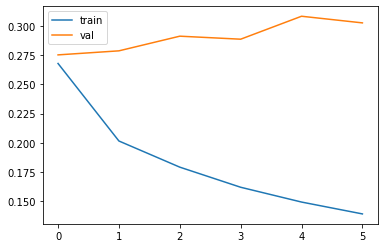

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [64]:
#Выгружаю веса из наилучшей эпохи
pretraied_model = entire_model_create()
pretraied_model.load_weights("dessc_RNN_model.h5")

In [83]:
predictions = tpu_entire_model.predict([encoded_descs_val, encoded_titles_val, cat_features_val]) > 0.5
print(classification_report(predictions, df_val.is_bad, digits=4))

              precision    recall  f1-score   support

       False     0.9568    0.9229    0.9396     12707
        True     0.7538    0.8501    0.7991      3530

    accuracy                         0.9071     16237
   macro avg     0.8553    0.8865    0.8693     16237
weighted avg     0.9127    0.9071    0.9090     16237



## RNN method final score

In [81]:
rocauc_avg = 0
for cat in df_val['category_num'].unique():
  cat_mask = df_val['category_num']==cat
  cat_rocauc = roc_auc_score(df_val[cat_mask].is_bad,
                              tpu_entire_model.predict([encoded_descs_val[cat_mask],
                                                        encoded_titles_val[cat_mask], 
                                                        cat_features_val[cat_mask]]
                                                       )
                              )
  rocauc_avg += cat_rocauc
print('Average ROC_AUC among categories')
print(rocauc_avg/len(df_val['category_num'].unique()))

Average ROC_AUC among categories
0.8902084666428131


# Coclusion
As we can see, neural network with LSTM layers allowed us to **increase our metric** by ~0.01. Moreover, **implementation** of an ensemble model requires more **time** and **precise parameters tuning** when implementation of NN model is quite fast and it does not take much time to tune the model. </br>
But there is a con about implemented neural network. **Learning requires too much time if one does not use TPU or CPU.** </br>
That is why in different situations we will use different solutions.